# 从csv中读取数据，onehot编码+归一化处理

In [152]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load_data():
    num_cols = [
        "number of rooms",
        "security level of the community",
        "residence space",
        "noise level",
        "waterfront",
        "view",
        "air quality level",
        "aboveground space",
        "building year",
        "decoration year",
        "is_renovated",
        "lat",
        "lng",
    ]
    cat_cols = [
        "city",
        "zip code",
    ]

    feature_names = cat_cols + num_cols
    df = pd.read_csv("./Train_Data_For_Task2.csv")
    features = df[feature_names]
    features = pd.get_dummies(features, columns=cat_cols)

    scaler = StandardScaler()
    features[num_cols] = scaler.fit_transform(features[num_cols])

    features = features.to_numpy()
    labels = df["label"].to_numpy()

    x_train, x_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.1, random_state=42)
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.linear_model import Ridge

model = RandomForestRegressor(n_estimators=260, max_features = 0.3)
model.fit(x_train, y_train)
accuracy = model.score(x_test, y_test)
print(accuracy)

0.7820944726097301


# MyModel定义，满足feature->label的训练

In [154]:
import torch
import torch.nn as nn

# 定义模型类
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(132, 64)
        self.fc2 = nn.Linear(64, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

model = MyModel()
model

MyModel(
  (fc1): Linear(in_features=132, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

# MyDataset定义，满足本地学习

In [155]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return torch.tensor(self.x[index]).to(torch.float32), torch.tensor(self.y[index])

batchsize = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = MyDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
test_dataset = MyDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True)


In [156]:
for item in dataloader:
  print(item)
  break

[tensor([[-0.4928,  0.4356,  0.1015,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4928, -0.2311, -0.0204,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4928, -0.8978, -0.5411,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4928, -0.5645, -0.7515,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6480, -0.2311,  1.1096,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.6480,  1.1024, -0.5632,  ...,  0.0000,  0.0000,  0.0000]]), tensor([1, 0, 0, 1, 0, 0, 1, 3, 1, 2, 1, 0, 2, 0, 0, 0, 0, 1, 3, 1, 2, 0, 1, 1,
        3, 2, 0, 1, 2, 3, 1, 0, 2, 0, 1, 1, 1, 3, 2, 3, 0, 3, 1, 3, 0, 1, 1, 1,
        2, 0, 2, 1, 1, 3, 3, 1, 2, 0, 1, 1, 1, 0, 2, 3, 1, 0, 2, 1, 2, 3, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 2, 3, 0, 1, 2, 2, 0, 0, 1, 2, 1, 1, 1, 2, 0, 3,
        1, 2, 0, 1, 2, 0, 1, 0, 1, 2, 1, 1, 3, 2, 0, 1, 1, 0, 2, 0, 1, 2, 0, 2,
        1, 3, 1, 0, 1, 0, 3, 1])]


# 传统训练方式 准确率大概在76%

In [157]:
def inference(model, testloader):
    """ Returns the inference accuracy and loss.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    loss, total, correct = 0.0, 0.0, 0.0
    for batch_idx, (features, labels) in enumerate(testloader):
        features, labels = features.to(device), labels.to(device)

        # Inference
        outputs = model(features)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
    loss /= batch_idx
    accuracy = correct/total
    return accuracy, loss

In [158]:
def train(epoch):
    dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    criterion = nn.CrossEntropyLoss().to(device)
    model = MyModel()
    model.train()
    epoch_loss = []
    epoch_test_loss = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for iter in range(epoch):
        batch_loss = []

        for batch_idx, (features, labels) in enumerate(dataloader):
            features, labels = features.to(device), labels.to(device)
            model.zero_grad()
            logits = model(features)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print('Epoch : {} | [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    iter, batch_idx * len(features),
                    len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
            batch_loss.append(loss.item())
        
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
    
    test_acc, test_loss = inference(model, test_loader)
    print('the global accuracy is {:.3}%, and the global loss is {:.3}.'.format(100 * test_acc, test_loss))

train(epoch=100)

Epoch : 0 | [0/3600 (0%)]	Loss: 1.391001
Epoch : 0 | [1280/3600 (34%)]	Loss: 1.374014
Epoch : 0 | [2560/3600 (69%)]	Loss: 1.354569
Epoch : 1 | [0/3600 (0%)]	Loss: 1.337297
Epoch : 1 | [1280/3600 (34%)]	Loss: 1.321786
Epoch : 1 | [2560/3600 (69%)]	Loss: 1.305164
Epoch : 2 | [0/3600 (0%)]	Loss: 1.259068
Epoch : 2 | [1280/3600 (34%)]	Loss: 1.252629
Epoch : 2 | [2560/3600 (69%)]	Loss: 1.215553
Epoch : 3 | [0/3600 (0%)]	Loss: 1.176455
Epoch : 3 | [1280/3600 (34%)]	Loss: 1.223342
Epoch : 3 | [2560/3600 (69%)]	Loss: 1.145150
Epoch : 4 | [0/3600 (0%)]	Loss: 1.140641
Epoch : 4 | [1280/3600 (34%)]	Loss: 1.131976
Epoch : 4 | [2560/3600 (69%)]	Loss: 1.115955
Epoch : 5 | [0/3600 (0%)]	Loss: 1.127918
Epoch : 5 | [1280/3600 (34%)]	Loss: 1.096517
Epoch : 5 | [2560/3600 (69%)]	Loss: 1.084271
Epoch : 6 | [0/3600 (0%)]	Loss: 1.080878
Epoch : 6 | [1280/3600 (34%)]	Loss: 1.104367
Epoch : 6 | [2560/3600 (69%)]	Loss: 1.103650
Epoch : 7 | [0/3600 (0%)]	Loss: 1.111760
Epoch : 7 | [1280/3600 (34%)]	Loss: 1.1001

# dirichlet分布定义及使用

In [159]:
import numpy as np
def dirichlet_partition(training_data, testing_data, alpha, user_num):
    np.random.seed(2023)
    labels_train = training_data[1]
    labels_valid = testing_data[1]

    idxs_train = np.arange(len(labels_train))
    idxs_valid = np.arange(len(labels_valid))

    idxs_labels_train = np.vstack((idxs_train, labels_train))
    # print("idxs_labels_train 1: ", idxs_labels_train)
    idxs_labels_train = idxs_labels_train[:, idxs_labels_train[1,:].argsort()]
    # print("idxs_labels_train 2: ", idxs_labels_train)
    idxs_labels_valid = np.vstack((idxs_valid, labels_valid))
    idxs_labels_valid = idxs_labels_valid[:, idxs_labels_valid[1,:].argsort()]

    labels = np.unique(labels_train, axis=0)

    data_train_dict = data_organize(idxs_labels_train, labels)
    # print("data_train_dict[0]: ", data_train_dict[0])
    # print("data_train_dict[9]: ", data_train_dict[9])
    data_valid_dict = data_organize(idxs_labels_valid, labels)

    data_partition_profile_train = {}
    data_partition_profile_valid = {}


    for i in range(user_num):
        data_partition_profile_train[i] = []
        data_partition_profile_valid[i] = []

    ## Distribute rest data
    for label in data_train_dict:
        proportions = np.random.dirichlet(np.repeat(alpha, user_num))
        proportions_train = len(data_train_dict[label])*proportions
        proportions_valid = len(data_valid_dict[label]) * proportions

        for user in data_partition_profile_train:

            data_partition_profile_train[user]   \
                = set.union(set(np.random.choice(data_train_dict[label], int(proportions_train[user]) , replace = False)), data_partition_profile_train[user])
            data_train_dict[label] = list(set(data_train_dict[label])-data_partition_profile_train[user])


            data_partition_profile_valid[user] = set.union(set(
                np.random.choice(data_valid_dict[label], int(proportions_valid[user]),
                                 replace=False)), data_partition_profile_valid[user])
            data_valid_dict[label] = list(set(data_valid_dict[label]) - data_partition_profile_valid[user])


        while len(data_train_dict[label]) != 0:
            rest_data = data_train_dict[label][0]
            user = np.random.randint(0, user_num)
            data_partition_profile_train[user].add(rest_data)
            data_train_dict[label].remove(rest_data)

        while len(data_valid_dict[label]) != 0:
            rest_data = data_valid_dict[label][0]
            user = np.random.randint(0, user_num)
            data_partition_profile_valid[user].add(rest_data)
            data_valid_dict[label].remove(rest_data)

    for user in data_partition_profile_train:
        data_partition_profile_train[user] = list(data_partition_profile_train[user])
        data_partition_profile_valid[user] = list(data_partition_profile_valid[user])
        np.random.shuffle(data_partition_profile_train[user])
        np.random.shuffle(data_partition_profile_valid[user])

    return data_partition_profile_train, data_partition_profile_valid


def data_organize(idxs_labels, labels):
    data_dict = {}

    labels = np.unique(labels, axis=0)
    for one in labels:
        data_dict[one] = []

    for i in range(len(idxs_labels[1, :])):
        data_dict[idxs_labels[1, i]].append(idxs_labels[0, i])
    return data_dict

user_num = 5
alpha = 0.5
train_index, test_index = dirichlet_partition((x_train, y_train), (x_test, y_test), alpha=alpha, user_num=user_num)

In [160]:
from collections import Counter
from matplotlib import pyplot as plt
def visualize_partion():
  plt.figure(figsize=(10,10))
  for i in range(4):
    y_train_part = y_train[train_index[i]]
    label_counter = Counter(y_train_part)
    print(f"for part {i}")
    labels = []
    counts = []
    for label, count in label_counter.items():
      print(label, ":", count)
      labels.append(label)
      counts.append(count)
    plt.subplot(2, 2, i + 1)
    plt.title(f"client_{i+1}")
    plt.xlabel("label")
    plt.ylabel("count")
    plt.hist(y_train_part)
  plt.show()

for part 0
0 : 1
1 : 1
for part 1
0 : 753
1 : 1296
3 : 63
for part 2
3 : 178
2 : 689
0 : 1
for part 3
3 : 10
2 : 1


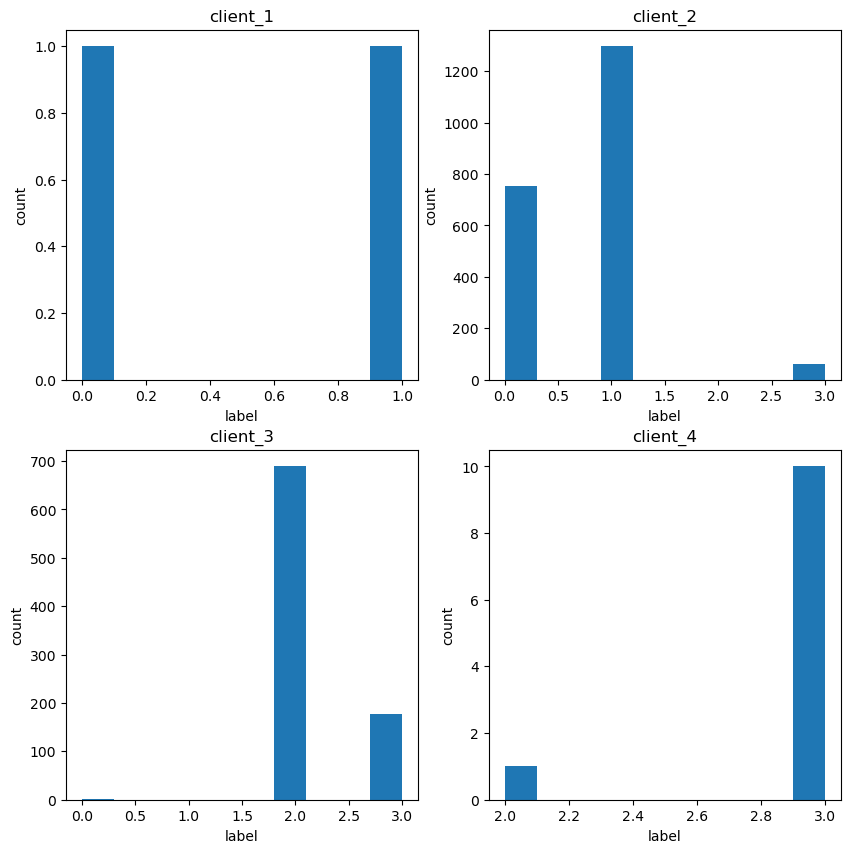

In [161]:
train_index, test_index = dirichlet_partition((x_train, y_train), (x_test, y_test), alpha=0.1, user_num=user_num)
visualize_partion()

for part 0
0 : 106
1 : 201
3 : 119
2 : 23
for part 1
1 : 393
2 : 627
3 : 53
0 : 7
for part 2
1 : 478
2 : 50
for part 3
0 : 540
1 : 228
3 : 130


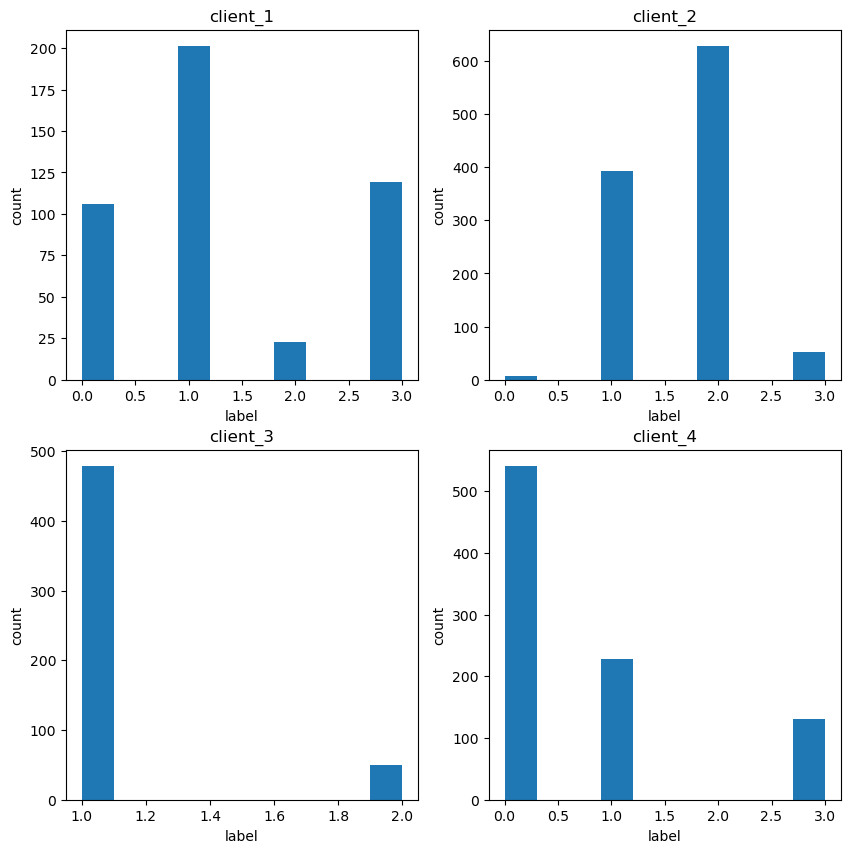

In [162]:
train_index, test_index = dirichlet_partition((x_train, y_train), (x_test, y_test), alpha=0.3, user_num=user_num)
visualize_partion()

for part 0
0 : 169
2 : 354
3 : 25
1 : 124
for part 1
1 : 181
3 : 374
0 : 32
2 : 12
for part 2
1 : 169
2 : 132
3 : 26
0 : 1
for part 3
0 : 452
1 : 524
2 : 158
3 : 145


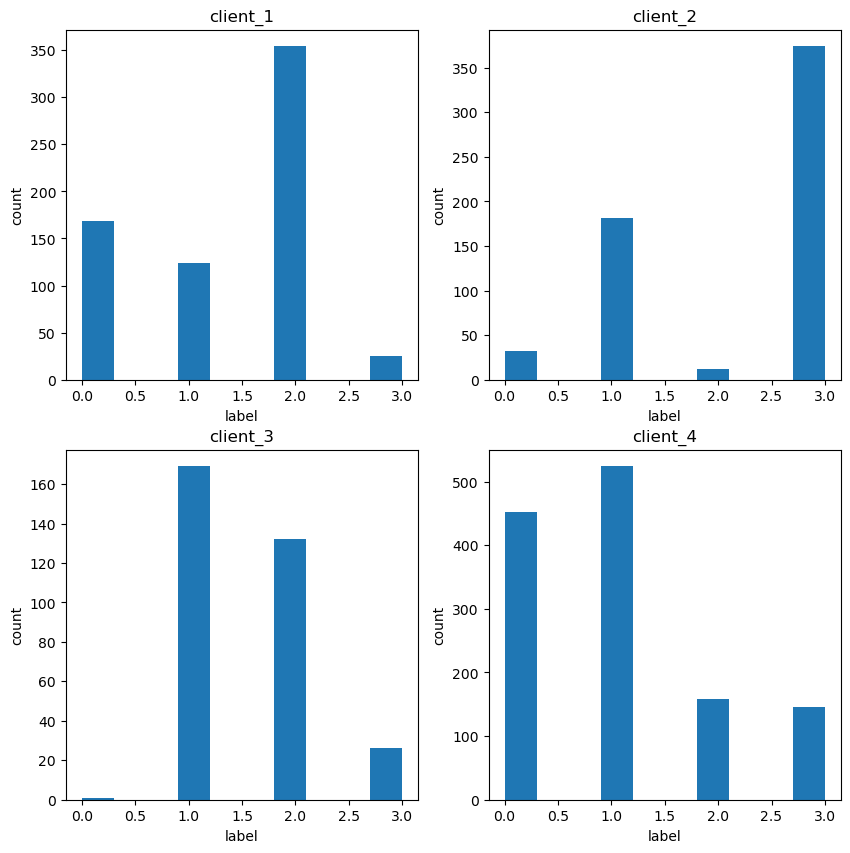

In [163]:
train_index, test_index = dirichlet_partition((x_train, y_train), (x_test, y_test), alpha=0.5, user_num=user_num)
visualize_partion()

for part 0
1 : 287
2 : 278
0 : 102
3 : 171
for part 1
0 : 582
2 : 118
1 : 88
3 : 108
for part 2
0 : 234
3 : 76
2 : 131
1 : 186
for part 3
2 : 96
3 : 25
1 : 43
0 : 36


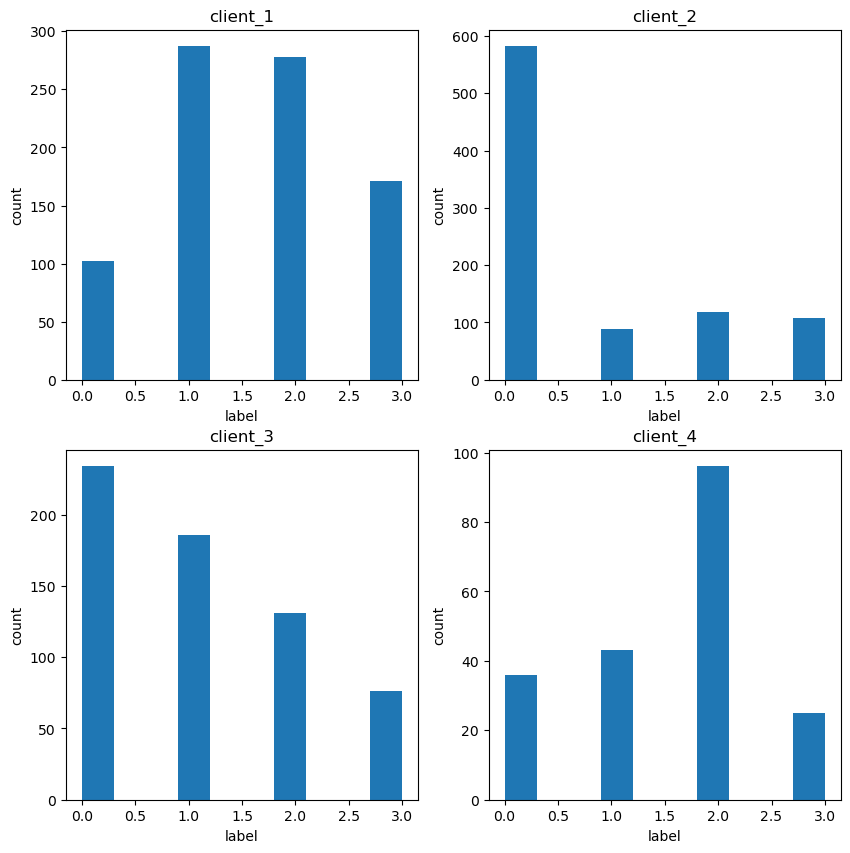

In [164]:
train_index, test_index = dirichlet_partition((x_train, y_train), (x_test, y_test), alpha=1, user_num=user_num)
visualize_partion()

# MyDatasetForFederal定义，满足联邦学习

In [ ]:
class MyDatasetForFederal(Dataset):
    def __init__(self, x, y, idxs):
        self.x = x
        self.y = y
        self.idxs = idxs

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, index):
        xx = torch.tensor(self.x[self.idxs[index]]).to(torch.float32)
        yy = torch.tensor(self.y[self.idxs[index]])
        return xx, yy 

train_data_list = []
for user_index in range(user_num):
    train_data_list.append(MyDatasetForFederal(x_train, y_train, train_index[user_index]))

# 联邦学习核心函数

In [ ]:
def local_trainer(dataset, model, global_round, device, local_epoch, batchsize, log=False):
    dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    criterion = nn.CrossEntropyLoss().to(device)
    model.train()
    epoch_loss = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for iter in range(local_epoch):
        batch_loss = []
        for batch_idx, (features, labels) in enumerate(dataloader):
            features, labels = features.to(device), labels.to(device)
            model.zero_grad()
            logits = model(features)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            if log and batch_idx % 10 == 0:
                print('| Global Round : {} | Local Epoch : {} | [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    global_round, iter, batch_idx * len(features),
                    len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
            batch_loss.append(loss.item())
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
    return model.state_dict(), sum(epoch_loss) / len(epoch_loss)

In [ ]:
import copy
def average_weights(w):
    """
    Returns the average of the weights.
    """
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key].float(), len(w))
    return w_avg

In [167]:
def federal_train_avg(log=False):
  global_model = MyModel().to(device)
  global_rounds = 100
  local_epochs = 5
  history = {
     "acc": [],
     "loss": [],
     "loss-client1": [],
     "loss-client2": [],
     "loss-client3": [],
     "loss-client4": [],
  }
  for round_idx in range(global_rounds):
    local_weights = []

    for user_index in range(4):
        model_weights, loss = local_trainer(train_data_list[user_index], copy.deepcopy(global_model), round_idx, device, local_epochs, batchsize,log)
        local_weights.append(copy.deepcopy(model_weights))
        history[f'loss-client{user_index+1}'].append(loss)

    global_weight = average_weights(local_weights)
    global_model.load_state_dict(global_weight)
    test_acc, test_loss = inference(global_model, test_loader)
    history["acc"].append(test_acc)
    history["loss"].append(test_loss)

    print('Global Round :{}, the global accuracy is {:.3}%, and the global loss is {:.3}.'.format(round_idx, 100 * test_acc, test_loss))
  
  return history

history = federal_train_avg()

Global Round :0, the global accuracy is 46.8%, and the global loss is 1.8.
Global Round :1, the global accuracy is 46.5%, and the global loss is 1.75.
Global Round :2, the global accuracy is 49.0%, and the global loss is 1.69.
Global Round :3, the global accuracy is 51.2%, and the global loss is 1.66.
Global Round :4, the global accuracy is 56.2%, and the global loss is 1.61.
Global Round :5, the global accuracy is 60.2%, and the global loss is 1.57.
Global Round :6, the global accuracy is 62.5%, and the global loss is 1.52.
Global Round :7, the global accuracy is 63.0%, and the global loss is 1.5.
Global Round :8, the global accuracy is 64.5%, and the global loss is 1.52.
Global Round :9, the global accuracy is 65.8%, and the global loss is 1.45.
Global Round :10, the global accuracy is 67.2%, and the global loss is 1.43.
Global Round :11, the global accuracy is 68.8%, and the global loss is 1.44.
Global Round :12, the global accuracy is 69.8%, and the global loss is 1.44.
Global Roun

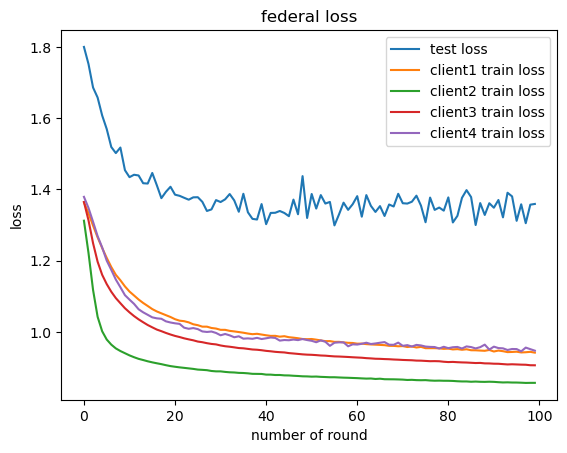

In [170]:
from matplotlib import pyplot as plt
plt.title("federal loss")
plt.xlabel("number of round")
plt.ylabel("loss")
plt.plot(range(100),history["loss"],label="test loss")
plt.plot(range(100),history["loss-client1"],label="client1 train loss")
plt.plot(range(100),history["loss-client2"],label="client2 train loss")
plt.plot(range(100),history["loss-client3"],label="client3 train loss")
plt.plot(range(100),history["loss-client4"],label="client4 train loss")
plt.legend()

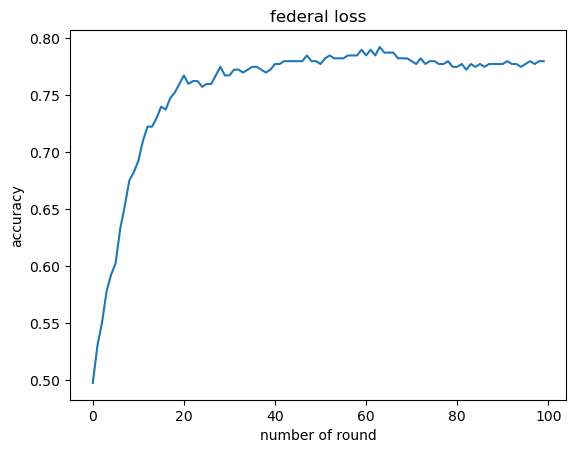

In [ ]:
from matplotlib import pyplot as plt
plt.title("federal loss")
plt.xlabel("number of round")
plt.ylabel("accuracy")
plt.plot(range(100),history["acc"])

# 演示dirichlet分布不同alpha值，训练效果的差别

## alpha=0.1, the global accuracy is 59.0%, and the global loss is 1.53.

In [ ]:
train_index, test_index = dirichlet_partition((x_train, y_train), (x_test, y_test), alpha=0.1, user_num=user_num)
train_data_list = []
for user_index in range(user_num):
    train_data_list.append(MyDatasetForFederal(x_train, y_train, train_index[user_index]))
federal_train_avg()

Global Round :0, the global accuracy is 45.0%, and the global loss is 1.82.
Global Round :1, the global accuracy is 51.0%, and the global loss is 1.77.
Global Round :2, the global accuracy is 53.0%, and the global loss is 1.72.
Global Round :3, the global accuracy is 54.2%, and the global loss is 1.66.
Global Round :4, the global accuracy is 55.2%, and the global loss is 1.66.
Global Round :5, the global accuracy is 56.2%, and the global loss is 1.64.
Global Round :6, the global accuracy is 57.5%, and the global loss is 1.59.
Global Round :7, the global accuracy is 57.8%, and the global loss is 1.58.
Global Round :8, the global accuracy is 58.2%, and the global loss is 1.59.
Global Round :9, the global accuracy is 58.8%, and the global loss is 1.54.
Global Round :10, the global accuracy is 59.0%, and the global loss is 1.57.
Global Round :11, the global accuracy is 59.0%, and the global loss is 1.56.
Global Round :12, the global accuracy is 59.2%, and the global loss is 1.55.
Global Ro

## alpha=0.3, the global accuracy is 61.8%, and the global loss is 1.47.

In [ ]:
train_index, test_index = dirichlet_partition((x_train, y_train), (x_test, y_test), alpha=0.3, user_num=user_num)
train_data_list = []
for user_index in range(user_num):
    train_data_list.append(MyDatasetForFederal(x_train, y_train, train_index[user_index]))
federal_train_avg()

Global Round :0, the global accuracy is 46.8%, and the global loss is 1.82.
Global Round :1, the global accuracy is 51.2%, and the global loss is 1.77.
Global Round :2, the global accuracy is 53.8%, and the global loss is 1.71.
Global Round :3, the global accuracy is 56.0%, and the global loss is 1.68.
Global Round :4, the global accuracy is 56.5%, and the global loss is 1.66.
Global Round :5, the global accuracy is 57.5%, and the global loss is 1.63.
Global Round :6, the global accuracy is 59.0%, and the global loss is 1.59.
Global Round :7, the global accuracy is 58.8%, and the global loss is 1.57.
Global Round :8, the global accuracy is 59.0%, and the global loss is 1.58.
Global Round :9, the global accuracy is 59.8%, and the global loss is 1.55.
Global Round :10, the global accuracy is 59.8%, and the global loss is 1.54.
Global Round :11, the global accuracy is 60.0%, and the global loss is 1.49.
Global Round :12, the global accuracy is 60.2%, and the global loss is 1.54.
Global Ro

## alpha=0.5, the global accuracy is 73.0%, and the global loss is 1.39.

In [ ]:
train_index, test_index = dirichlet_partition((x_train, y_train), (x_test, y_test), alpha=0.5, user_num=user_num)
train_data_list = []
for user_index in range(user_num):
    train_data_list.append(MyDatasetForFederal(x_train, y_train, train_index[user_index]))
federal_train_avg()

Global Round :0, the global accuracy is 53.0%, and the global loss is 1.79.
Global Round :1, the global accuracy is 53.2%, and the global loss is 1.74.
Global Round :2, the global accuracy is 53.5%, and the global loss is 1.7.
Global Round :3, the global accuracy is 56.0%, and the global loss is 1.63.
Global Round :4, the global accuracy is 57.2%, and the global loss is 1.62.
Global Round :5, the global accuracy is 58.2%, and the global loss is 1.54.
Global Round :6, the global accuracy is 59.2%, and the global loss is 1.54.
Global Round :7, the global accuracy is 60.8%, and the global loss is 1.5.
Global Round :8, the global accuracy is 62.3%, and the global loss is 1.49.
Global Round :9, the global accuracy is 64.0%, and the global loss is 1.5.
Global Round :10, the global accuracy is 65.2%, and the global loss is 1.46.
Global Round :11, the global accuracy is 67.2%, and the global loss is 1.46.
Global Round :12, the global accuracy is 68.8%, and the global loss is 1.44.
Global Round

## alpha=1, the global accuracy is 74.5%, and the global loss is 1.35.

In [ ]:
train_index, test_index = dirichlet_partition((x_train, y_train), (x_test, y_test), alpha=1, user_num=user_num)
train_data_list = []
for user_index in range(user_num):
    train_data_list.append(MyDatasetForFederal(x_train, y_train, train_index[user_index]))
federal_train_avg()

Global Round :0, the global accuracy is 55.0%, and the global loss is 1.8.
Global Round :1, the global accuracy is 57.0%, and the global loss is 1.75.
Global Round :2, the global accuracy is 56.5%, and the global loss is 1.66.
Global Round :3, the global accuracy is 57.5%, and the global loss is 1.64.
Global Round :4, the global accuracy is 60.8%, and the global loss is 1.57.
Global Round :5, the global accuracy is 63.2%, and the global loss is 1.54.
Global Round :6, the global accuracy is 65.2%, and the global loss is 1.56.
Global Round :7, the global accuracy is 67.0%, and the global loss is 1.55.
Global Round :8, the global accuracy is 67.5%, and the global loss is 1.49.
Global Round :9, the global accuracy is 68.8%, and the global loss is 1.46.
Global Round :10, the global accuracy is 68.5%, and the global loss is 1.42.
Global Round :11, the global accuracy is 69.8%, and the global loss is 1.4.
Global Round :12, the global accuracy is 71.2%, and the global loss is 1.5.
Global Round

# 缓解方案

## 原来模型, 使用alpha=0.3, 准确率大概60%

In [ ]:
train_index, test_index = dirichlet_partition((x_train, y_train), (x_test, y_test), alpha=0.3, user_num=user_num)
train_data_list = []
for user_index in range(user_num):
    train_data_list.append(MyDatasetForFederal(x_train, y_train, train_index[user_index]))

In [ ]:
federal_train_avg()

Global Round :0, the global accuracy is 43.8%, and the global loss is 1.81.
Global Round :1, the global accuracy is 49.2%, and the global loss is 1.79.
Global Round :2, the global accuracy is 52.0%, and the global loss is 1.74.
Global Round :3, the global accuracy is 53.8%, and the global loss is 1.69.
Global Round :4, the global accuracy is 56.5%, and the global loss is 1.64.
Global Round :5, the global accuracy is 57.8%, and the global loss is 1.63.
Global Round :6, the global accuracy is 58.2%, and the global loss is 1.6.
Global Round :7, the global accuracy is 58.2%, and the global loss is 1.58.
Global Round :8, the global accuracy is 59.2%, and the global loss is 1.62.
Global Round :9, the global accuracy is 59.2%, and the global loss is 1.58.
Global Round :10, the global accuracy is 59.5%, and the global loss is 1.58.
Global Round :11, the global accuracy is 59.8%, and the global loss is 1.54.
Global Round :12, the global accuracy is 60.0%, and the global loss is 1.53.
Global Rou

## 缓解方案1： 添加一个BatchNorm1d, 准确率大概67%

In [ ]:
# 定义模型类（添加一个BatchNorm1d）
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(132, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        # 添加一个BatchNorm1d
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
federal_train_avg()

Global Round :0, the global accuracy is 52.2%, and the global loss is 1.77.
Global Round :1, the global accuracy is 57.8%, and the global loss is 1.67.
Global Round :2, the global accuracy is 58.8%, and the global loss is 1.65.
Global Round :3, the global accuracy is 59.0%, and the global loss is 1.58.
Global Round :4, the global accuracy is 60.0%, and the global loss is 1.57.
Global Round :5, the global accuracy is 60.2%, and the global loss is 1.56.
Global Round :6, the global accuracy is 61.3%, and the global loss is 1.55.
Global Round :7, the global accuracy is 62.0%, and the global loss is 1.57.
Global Round :8, the global accuracy is 62.3%, and the global loss is 1.55.
Global Round :9, the global accuracy is 62.3%, and the global loss is 1.52.
Global Round :10, the global accuracy is 63.2%, and the global loss is 1.51.
Global Round :11, the global accuracy is 64.2%, and the global loss is 1.51.
Global Round :12, the global accuracy is 64.8%, and the global loss is 1.49.
Global Ro

In [ ]:
# 还原模型定义
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(132, 64)
        self.fc2 = nn.Linear(64, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## 缓解方案2：每轮迭代随机选取2个客户端参与训练，准确率波动比较大，准确率最高可以到70%

In [ ]:
def federal_train_avg_sample_the_client():
  global_model = MyModel().to(device)
  # 因为每次只有两个客户端参与，所以rounds变成了50
  global_rounds = 50
  local_epochs = 5
  for round_idx in range(global_rounds):
      local_weights = []
      local_losses = []
      global_acc = []

      for user_index in np.random.choice(range(user_num), size=2, replace=False):
          model_weights, loss = local_trainer(train_data_list[user_index], copy.deepcopy(global_model), round_idx, device, local_epochs, batchsize)
          local_weights.append(copy.deepcopy(model_weights))
          local_losses.append(loss)

      global_weight = average_weights(local_weights)
      global_model.load_state_dict(global_weight)
      test_acc, test_loss = inference(global_model, test_loader)
      print('Global Round :{}, the global accuracy is {:.3}%, and the global loss is {:.3}.'.format(round_idx, 100 * test_acc, test_loss))

federal_train_avg_sample_the_client()

Global Round :0, the global accuracy is 41.2%, and the global loss is 1.82.
Global Round :1, the global accuracy is 41.0%, and the global loss is 1.77.
Global Round :2, the global accuracy is 38.0%, and the global loss is 1.72.
Global Round :3, the global accuracy is 51.7%, and the global loss is 1.71.
Global Round :4, the global accuracy is 43.5%, and the global loss is 1.7.
Global Round :5, the global accuracy is 56.0%, and the global loss is 1.6.
Global Round :6, the global accuracy is 47.0%, and the global loss is 1.66.
Global Round :7, the global accuracy is 52.0%, and the global loss is 1.63.
Global Round :8, the global accuracy is 54.8%, and the global loss is 1.57.
Global Round :9, the global accuracy is 57.2%, and the global loss is 1.53.
Global Round :10, the global accuracy is 58.5%, and the global loss is 1.57.
Global Round :11, the global accuracy is 45.5%, and the global loss is 1.67.
Global Round :12, the global accuracy is 45.0%, and the global loss is 1.65.
Global Roun